In [27]:
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

First, define a gravitational potential.

In [28]:
pot = gp.MilkyWayPotential()

Select a star.

In [29]:
dict5 = {
    'ra': 139.4978105603, #degree
    'e_ra': 0.0001, #degree
    'dec': 67.3773227272, #degree
    'e_dec': 0.0001, #degree
    'dist': 44.20, #kpc
    'e_dist': 5.09, #kpc
    'pmra': 0.00, #mas/yr
    'e_pmra': 0.08, #mas/yr
    'pmdec': -0.99, #mas/yr
    'e_pmdec': 0.11, #mas/yr
    'rv': 545.50, #km/s
    'e_rv': 4.30, #km/s
    }

hvs5 = coord.SkyCoord(
    ra=dict5['ra'] * u.degree,
    dec=dict5['dec'] * u.degree,
    distance=dict5['dist'] * u.kpc,
    pm_ra_cosdec=dict5['pmra'] * (u.mas / u.yr),
    pm_dec=dict5['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict5['rv'] * (u.km / u.s),
    frame="icrs"
)

hvs5_GC = hvs5.transform_to(coord.Galactocentric)

Set initial conditions and specify time-stepping

In [30]:
hvs5_ics = gd.PhaseSpacePosition(pos=hvs5_GC.cartesian.xyz, vel=hvs5_GC.velocity.d_xyz)
hvs5_orbit1 = pot.integrate_orbit(hvs5_ics, dt=-0.1*u.Myr, n_steps=10000) # 1 Gyr
hvs5_orbit2 = pot.integrate_orbit(hvs5_ics, dt=-0.1*u.Myr, n_steps=5000) # 500 Myr
hvs5_orbit3 = pot.integrate_orbit(hvs5_ics, dt=-0.1*u.Myr, n_steps=1000) # 100 Myr

        Use name instead. [gala.dynamics.core]


Sample 100 clones from the uncertainties.

In [31]:
n_samples = 1000
ra_samples = np.random.normal(dict5['ra'], dict5['e_ra'], n_samples)
dec_samples = np.random.normal(dict5['dec'], dict5['e_dec'], n_samples)
dist_samples = np.random.normal(dict5['dist'], dict5['e_dist'], n_samples)
pmra_samples = np.random.normal(dict5['pmra'], dict5['e_pmra'], n_samples)
pmdec_samples = np.random.normal(dict5['pmdec'], dict5['e_pmdec'], n_samples)
rv_samples = np.random.normal(dict5['rv'], dict5['e_rv'], n_samples)

ics_list = []
for ra, dec, dist, pmra, pmdec, rv in zip(ra_samples, dec_samples, dist_samples, pmra_samples, pmdec_samples, rv_samples):
    sc = coord.SkyCoord(ra=ra * u.degree,
                  dec=dec * u.degree,
                  distance=dist * u.kpc,
                  pm_ra_cosdec=pmra * (u.mas / u.yr),
                  pm_dec=pmdec * (u.mas / u.yr),
                  radial_velocity=rv * (u.km / u.s),
                  frame="icrs")
    gc = sc.transform_to(coord.Galactocentric)
    ics = gd.PhaseSpacePosition(pos=gc.cartesian.xyz, vel=gc.velocity.d_xyz)
    ics_list.append(ics)

Integrate all of the orbits

In [32]:
orbits1 = []
orbits2 = []
orbits3 = []
orbits1.append(hvs5_orbit1)
orbits2.append(hvs5_orbit2)
orbits3.append(hvs5_orbit3)
for ics in ics_list:
    orbit1 = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=10000)
    orbit2 = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=5000)
    orbit3 = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=1000)
    orbits1.append(orbit1)
    orbits2.append(orbit2)
    orbits3.append(orbit3)

Plot the final positions of the star after 1 Gyr

<Figure size 400x300 with 0 Axes>

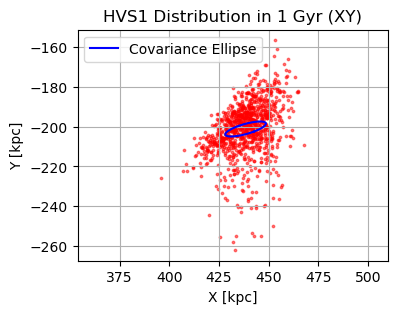

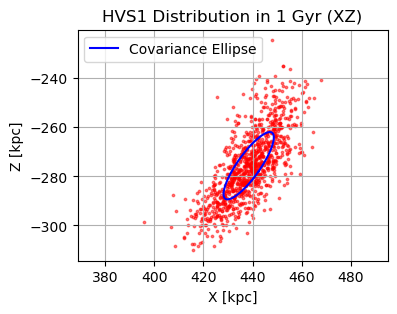

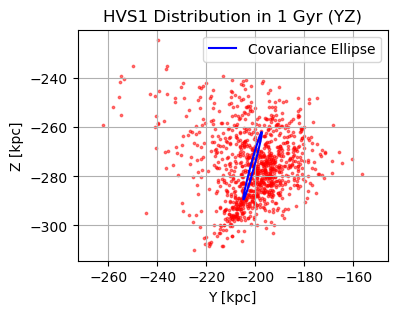

In [51]:
plt.figure(figsize=(4, 3))

red_points = []

for i, orbit in enumerate(orbits1):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        pass
        # plt.scatter(final_pos[0], final_pos[1], c='black', label='Original')
    else:
        # plt.scatter(final_pos[0], final_pos[1], c='red')
        red_points.append(final_pos)

# Covariance

red_points = np.array(red_points)

cov = np.cov(red_points.T)
mean_pos = np.mean(red_points, axis=0)

eigenvalues, eigenvectors = np.linalg.eig(cov)
axes_lengths = np.sqrt(eigenvalues)
theta = np.linspace(0, 2*np.pi, 200)
circle = np.array([np.cos(theta), np.sin(theta), np.zeros_like(theta)]) 
ellipse_3d = (eigenvectors @ (np.diag(axes_lengths) @ circle)) + mean_pos[:, np.newaxis]  # shape (3, 200)

ellipse_xy = ellipse_3d[[0, 1], :]
ellipse_xz = ellipse_3d[[0, 2], :]
ellipse_yz = ellipse_3d[[1, 2], :]


# XY Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_xy[0], ellipse_xy[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 0], red_points[:, 1], s=3, c='red', alpha=0.5)
plt.xlabel("X [kpc]")
plt.ylabel("Y [kpc]")
plt.title("HVS1 Distribution in 1 Gyr (XY)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# XZ Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_xz[0], ellipse_xz[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 0], red_points[:, 2], s=3, c='red', alpha=0.5)
plt.xlabel("X [kpc]")
plt.ylabel("Z [kpc]")
plt.title("HVS1 Distribution in 1 Gyr (XZ)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# YZ Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_yz[0], ellipse_yz[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 1], red_points[:, 2], s=3, c='red', alpha=0.5)
plt.xlabel("Y [kpc]")
plt.ylabel("Z [kpc]")
plt.title("HVS1 Distribution in 1 Gyr (YZ)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

Plot the final positions of the star after 500 Myr

Covariance matrix of red points:
[[28.65530473 18.2115359  26.61725766]
 [18.2115359  33.09430828  7.96289805]
 [26.61725766  7.96289805 54.87195236]]
Mean of red points: [ 208.90733403  -99.43386448 -136.2248802 ]


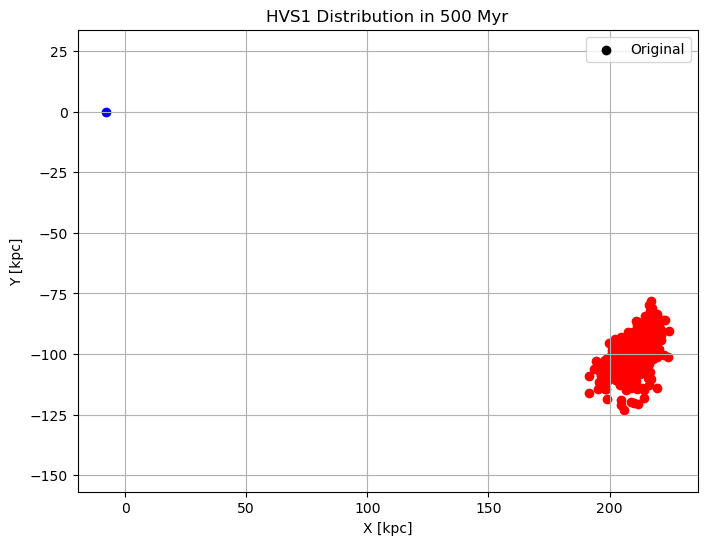

In [34]:
plt.figure(figsize=(8, 6))

red_points = []

for i, orbit in enumerate(orbits2):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        plt.scatter(final_pos[0], final_pos[1], c='black', label='Original')
    else:
        plt.scatter(final_pos[0], final_pos[1], c='red')
        red_points.append(final_pos)

# Covariance

red_points = np.array(red_points)

cov = np.cov(red_points.T)
print("Covariance matrix of red points:")
print(cov)

mean_pos = np.mean(red_points, axis=0)
print("Mean of red points:", mean_pos)

# Regular Plot

plt.xlabel('X [kpc]')
plt.scatter(-8,0, c='blue')
plt.ylabel('Y [kpc]')
plt.title('HVS1 Distribution in 500 Myr')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

Plot the final positions of the star after 100 Myr

Covariance matrix of red points:
[[12.56764507 -8.63006604 -5.84607969]
 [-8.63006604 11.76082913  6.66860952]
 [-5.84607969  6.66860952  5.91475848]]
Mean of red points: [ 12.11505806 -11.39220545 -15.49596224]


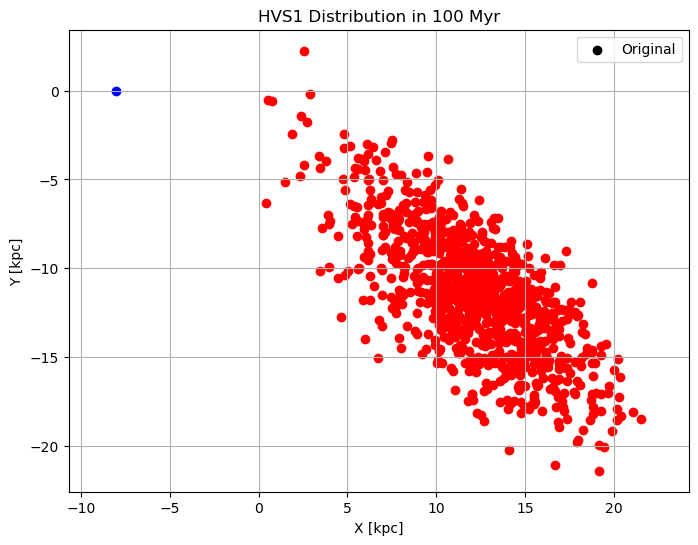

In [35]:
plt.figure(figsize=(8, 6))

red_points = []

for i, orbit in enumerate(orbits3):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        plt.scatter(final_pos[0], final_pos[1], c='black', label='Original')
    else:
        plt.scatter(final_pos[0], final_pos[1], c='red')
        red_points.append(final_pos)

# Covariance

red_points = np.array(red_points)

cov = np.cov(red_points.T)
print("Covariance matrix of red points:")
print(cov)

mean_pos = np.mean(red_points, axis=0)
print("Mean of red points:", mean_pos)

# Regular Plot

plt.xlabel('X [kpc]')
plt.scatter(-8,0, c='blue')
plt.ylabel('Y [kpc]')
plt.title('HVS1 Distribution in 100 Myr')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()